## WhatsApp Chat Analysis

In [15]:
import re
import regex
import pandas as pd
import emoji
import datetime

## Processing Data

In [16]:
def startsWithDateAndTimeAndroid(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

def startsWithDateAndTimeios(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])?[ ]?(AM|PM|am|pm)?\]' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [17]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [18]:
def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

def getDataPointios(line):
	splitLine = line.split('] ')
	dateTime = splitLine[0]
	if ',' in dateTime:
		date, time = dateTime.split(',')
	else:
		date, time = dateTime.split(' ', 1)
	message = ' '.join(splitLine[1:])
	if FindAuthor(message):
		splitMessage = message.split(':')
		author = splitMessage[0]
		message = ' '.join(splitMessage[1:])
	else:
		author = None
	if time[5]==":":
		time = time[:5]+time[-3:]
	else:
		if 'AM' in time or 'PM' in time:
			time = time[:6]+time[-3:]
		else:
			time = time[:6]
	return date, time, author, message

In [19]:
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d-%m-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%d-%m-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d/%m/%Y").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%m/%d/%y").strftime("%Y-%m-%d")

In [20]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

## Importing WhatsApp Database

In [21]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = 'WhatsApp Chat with.txt' # WhatsApp database path
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    print(first)
    if '[' in first:
      device='ios'
    else:
      device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        if device=="ios":
          line = line.strip()
          if startsWithDateAndTimeios(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointios(line)
            messageBuffer.append(message)
          else:
            line= (line.encode('ascii', 'ignore')).decode("utf-8")
            if startsWithDateAndTimeios(line):
              if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
              messageBuffer.clear()
              date, time, author, message = getDataPointios(line)
              messageBuffer.append(message)
            else:
              messageBuffer.append(line)
        else:
          line = line.strip()
          if startsWithDateAndTimeAndroid(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointAndroid(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)

17/12/2021, 12:40 - Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them. Tap to learn more.



In [22]:
if device =='android':
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.dropna()
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
else:
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
        df = df.dropna()
        df["Date"] = df["Date"].apply(dateconv)
        df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [23]:
df.head(2)

,Date,Time,Author,Message,emoji,urlcount
0,2021-12-17,18:28,JSS Raj,<Media omitted>,[],0
1,2021-12-17,19:34,JSS Raj,Exam date sheetbhejdo koi,[],0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14437 entries, 0 to 14697
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      14437 non-null  datetime64[ns]
 1   Time      14437 non-null  object        
 2   Author    14437 non-null  object        
 3   Message   14437 non-null  object        
 4   emoji     14437 non-null  object        
 5   urlcount  14437 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 789.5+ KB


In [25]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14437 entries, 0 to 14697
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      14437 non-null  datetime64[ns]
 1   Time      14437 non-null  object        
 2   Author    14437 non-null  object        
 3   Message   14437 non-null  object        
 4   emoji     14437 non-null  object        
 5   urlcount  14437 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 789.5+ KB


In [26]:
df.Author.unique()

array(['JSS Raj', 'Aakash', 'Shivam', 'JSS Rohit', 'Parker',
       'Biplav Singh', 'JSS Prashant', 'Harsh', 'Daku',
       'JSS Ayush Hostel', 'JSS Vatsal', 'JSS Tushar Ece', 'JSS Krishna',
       'JSS Shashank'], dtype=object)

## Grouping Data

In [27]:
#Counting unique user instances
df['Author'].value_counts()

JSS Prashant        3166
Shivam              2454
JSS Raj             1941
Harsh               1389
Daku                1359
JSS Ayush Hostel     884
Aakash               869
JSS Rohit            692
Biplav Singh         593
JSS Vatsal           356
Parker               297
JSS Tushar Ece       275
JSS Krishna          136
JSS Shashank          26
Name: Author, dtype: int64

## Plotting Data

<AxesSubplot:>

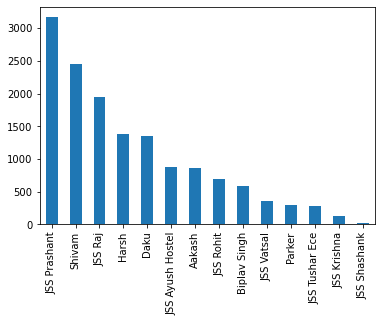

In [28]:
df['Author'].value_counts().plot(kind='bar')